In [62]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Importing Library

In [68]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

In [4]:
# We will set the seed for reproducibility.
np.random.seed(1234)  
PYTHONHASHSEED = 0
# This is donw so that our model produce same result after running multiple times.

# Data Loading

In [33]:
# Training data where the last cycle is the failure point for the engines
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)

# We wil print some rows of the train data
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


# Data Preprocessing

## Data Cleaning 
### Removing Null Values

In [34]:
# Let's drop the NAN columns 26 and 27 using the dropna() method.
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

In [35]:
print(len(train_df))
print(len(test_df))

20631
13096


## Assigning names to columns

In [36]:

cols_names = [
    'id', 'cycle', 'setting1', 'setting2', 'setting3',
    "(Fan inlet temperature) (◦R)",
    "(LPC outlet temperature) (◦R)",
    "(HPC outlet temperature) (◦R)",
    "(LPT outlet temperature) (◦R)",
    "(Fan inlet Pressure) (psia)",
    "(bypass-duct pressure) (psia)",
    "(HPC outlet pressure) (psia)",
    "(Physical fan speed) (rpm)",
    "(Physical core speed) (rpm)",
    "(Engine pressure ratio(P50/P2)",
    "(HPC outlet Static pressure) (psia)",
    "(Ratio of fuel flow to Ps30) (pps/psia)",
    "(Corrected fan speed) (rpm)",
    "(Corrected core speed) (rpm)",
    "(Bypass Ratio) ",
    "(Burner fuel-air ratio)",
    "(Bleed Enthalpy)",
    "(Required fan speed)",
    "(Required fan conversion speed)",
    "(High-pressure turbines Cool air flow)",
    "(Low-pressure turbines Cool air flow)"
]
  
train_df.columns = cols_names
test_df.columns = cols_names

train_df.head(2)

,id,cycle,setting1,setting2,setting3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [37]:
test_df.head(2)

,id,cycle,setting1,setting2,setting3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916


## Removing column that is null

In [38]:
# Load the ground truth for the test data, which indicates the remaining useful cycles for the engines

truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [39]:
# We wil drop the NAN column
truth_df.dropna(axis=1, inplace=True)
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


In [40]:
# method and specify which columns are to be considered while sorting using the parameter.

train_df.sort_values(['id','cycle'], inplace=True)
test_df.sort_values(['id','cycle'], inplace=True)

# EDA

In [41]:
# Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
train_df['RUL'] = train_df['max'] - train_df['cycle']

#The RUL is calculated for each id.
train_df[['id','cycle','max','RUL']].head()

,id,cycle,max,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [42]:
# We do not need "max" anymore.
train_df.drop('max', axis=1, inplace=True)

In [43]:
# We will make a label that indicates whether an engine is going to fail within w1 cycles.
w1 = 30
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

In [44]:
# Make a separate feature for the normalized value of the cycle column.
train_df['cycle_norm'] = train_df['cycle']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

#Join the normalized and non-normalized data.
join_df = train_df[['id','cycle','RUL','failure_within_w1']].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

,id,cycle,setting1,setting2,setting3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


In [45]:
# Let's calculate the total RUL by summing up the maximum cycles given in the test set and the 
# ground truth additional RUL.
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['additional_rul']

# The respective id can be obtained by adding 1 to the index, as the index starts from 0.
truth_df['id'] = truth_df.index + 1

# Add the max cycles given in the test set and the additional RUL given in the ground truth DataFrame.
truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

# Generate the RUL for the test data.
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# Generate the label columns w0 and w1 for the test data.
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL,failure_within_w1
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


<Axes: >

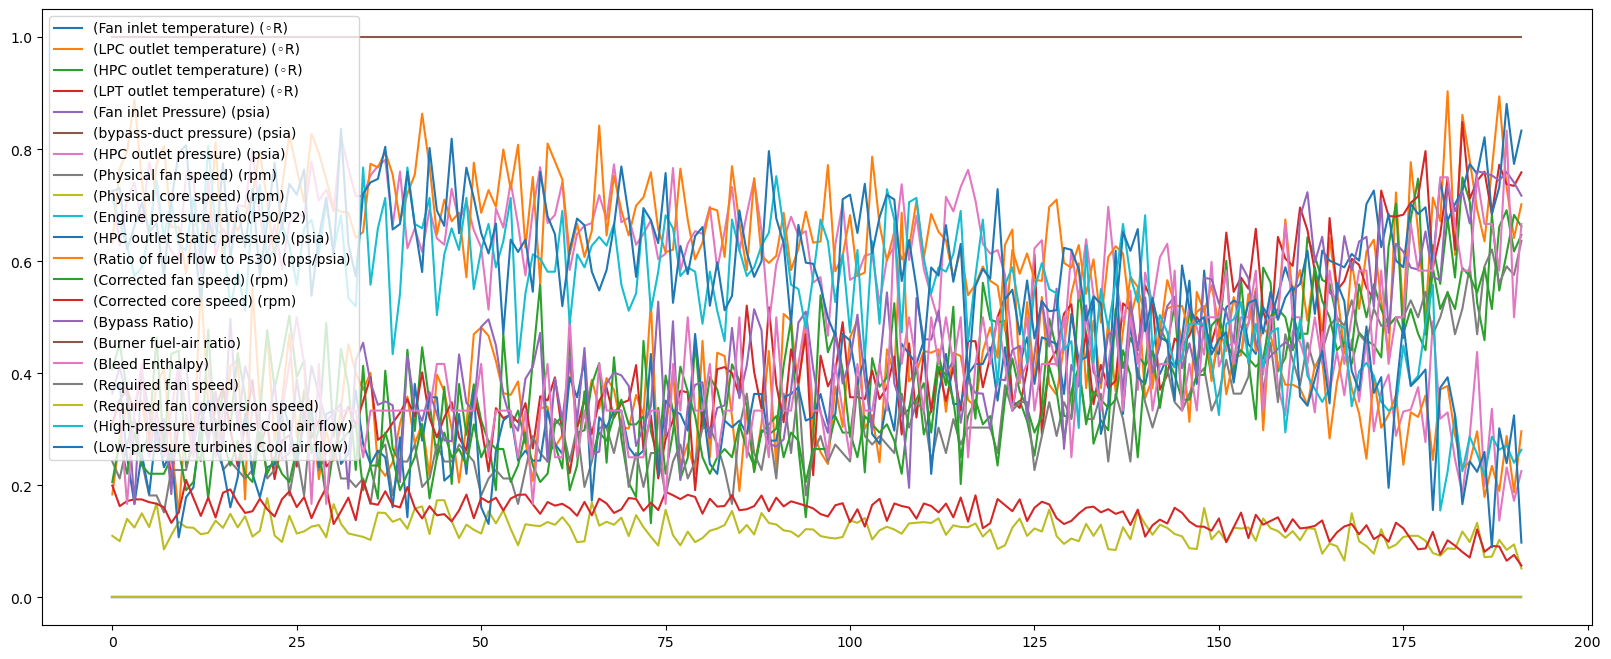

In [46]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(20, 8))

<Axes: >

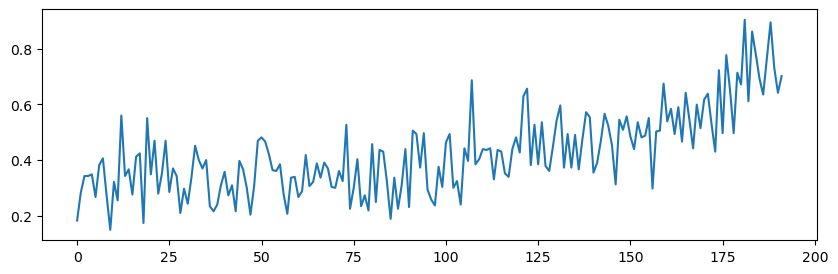

In [47]:
train_df[train_df.id==1][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

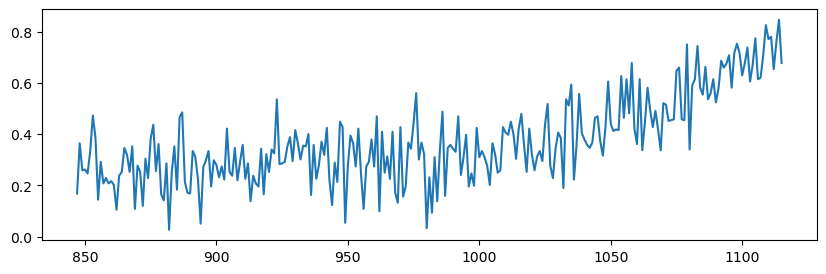

In [48]:
train_df[train_df.id==5][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

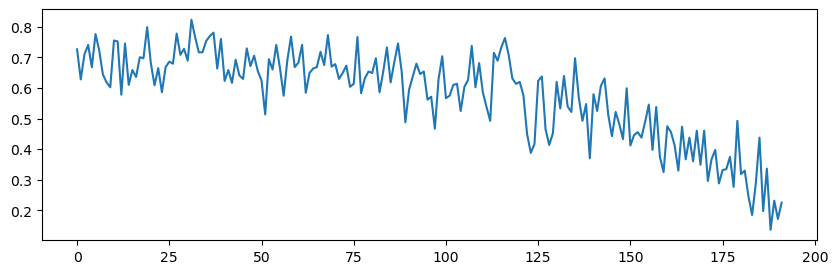

In [49]:
train_df[train_df.id==1][sensor_cols[6]].plot(figsize=(10, 3))

<Axes: >

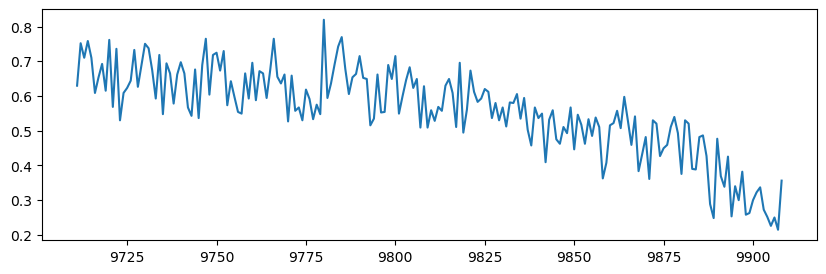

In [50]:
train_df[train_df.id==50][sensor_cols[6]].plot(figsize=(10, 3))

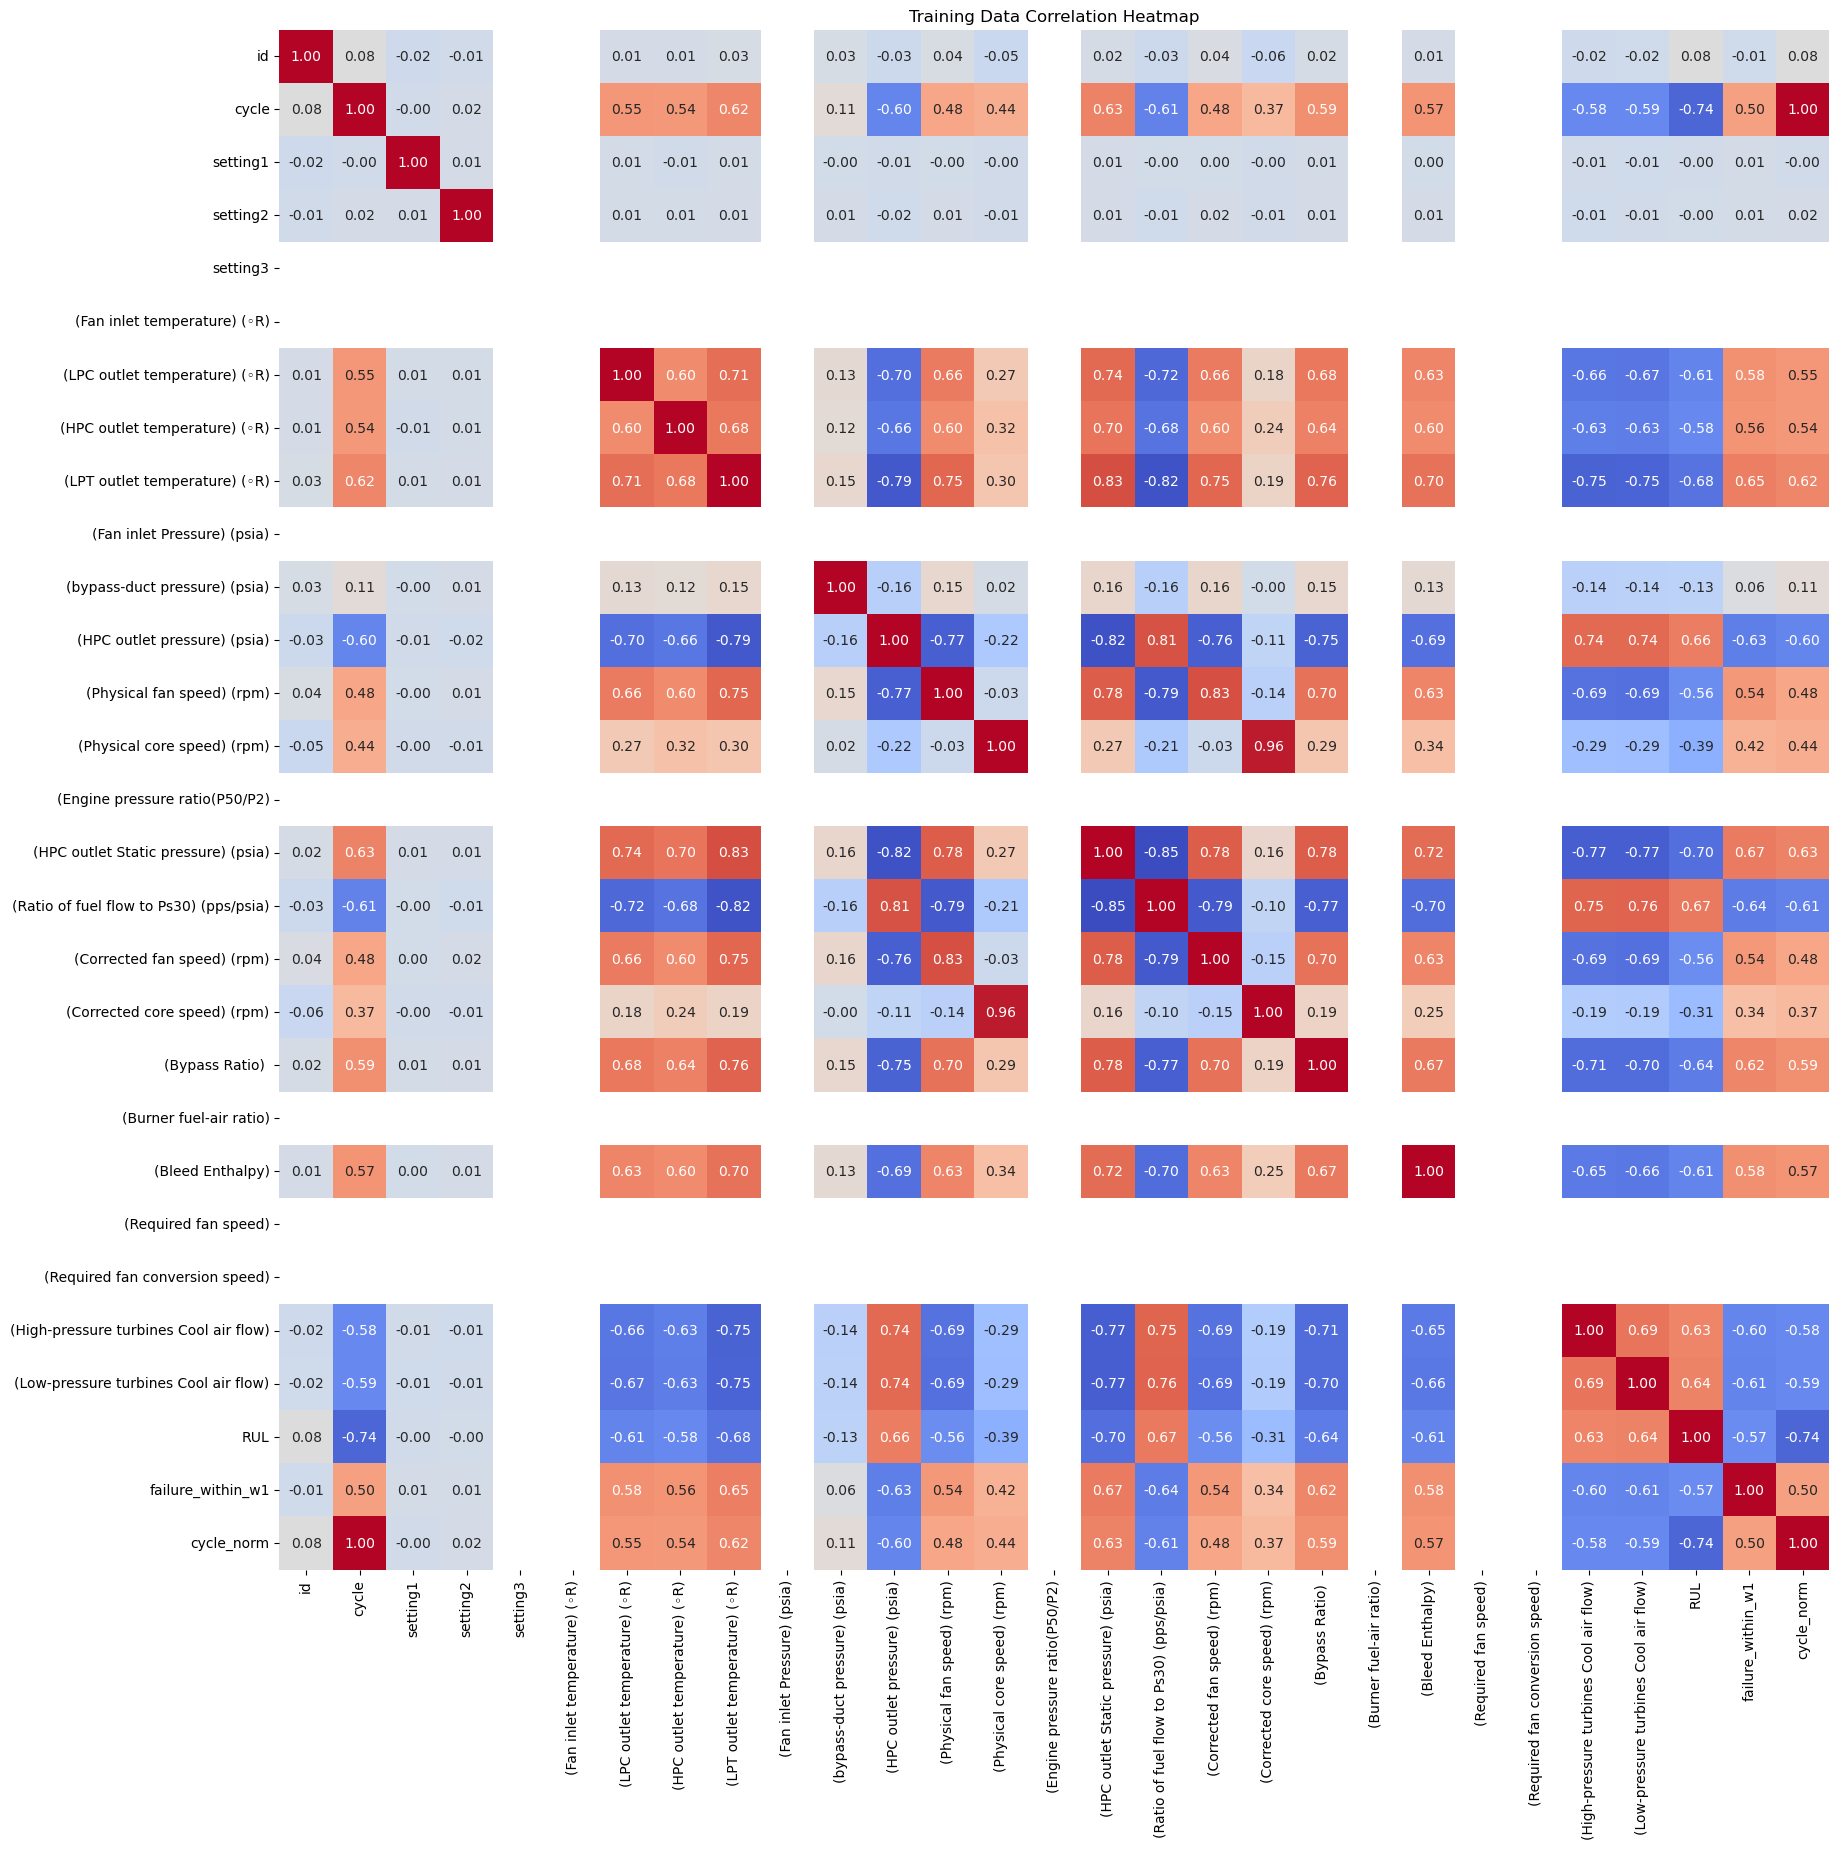

In [51]:
# Calculate the correlation matrices
train_corr = train_df.corr()
test_corr = test_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Plot the training data correlation heatmap
sns.heatmap(train_corr, annot=True, cmap='coolwarm', cbar=False, fmt=".2f")
plt.title('Training Data Correlation Heatmap')

# Display the heatmaps
plt.show()

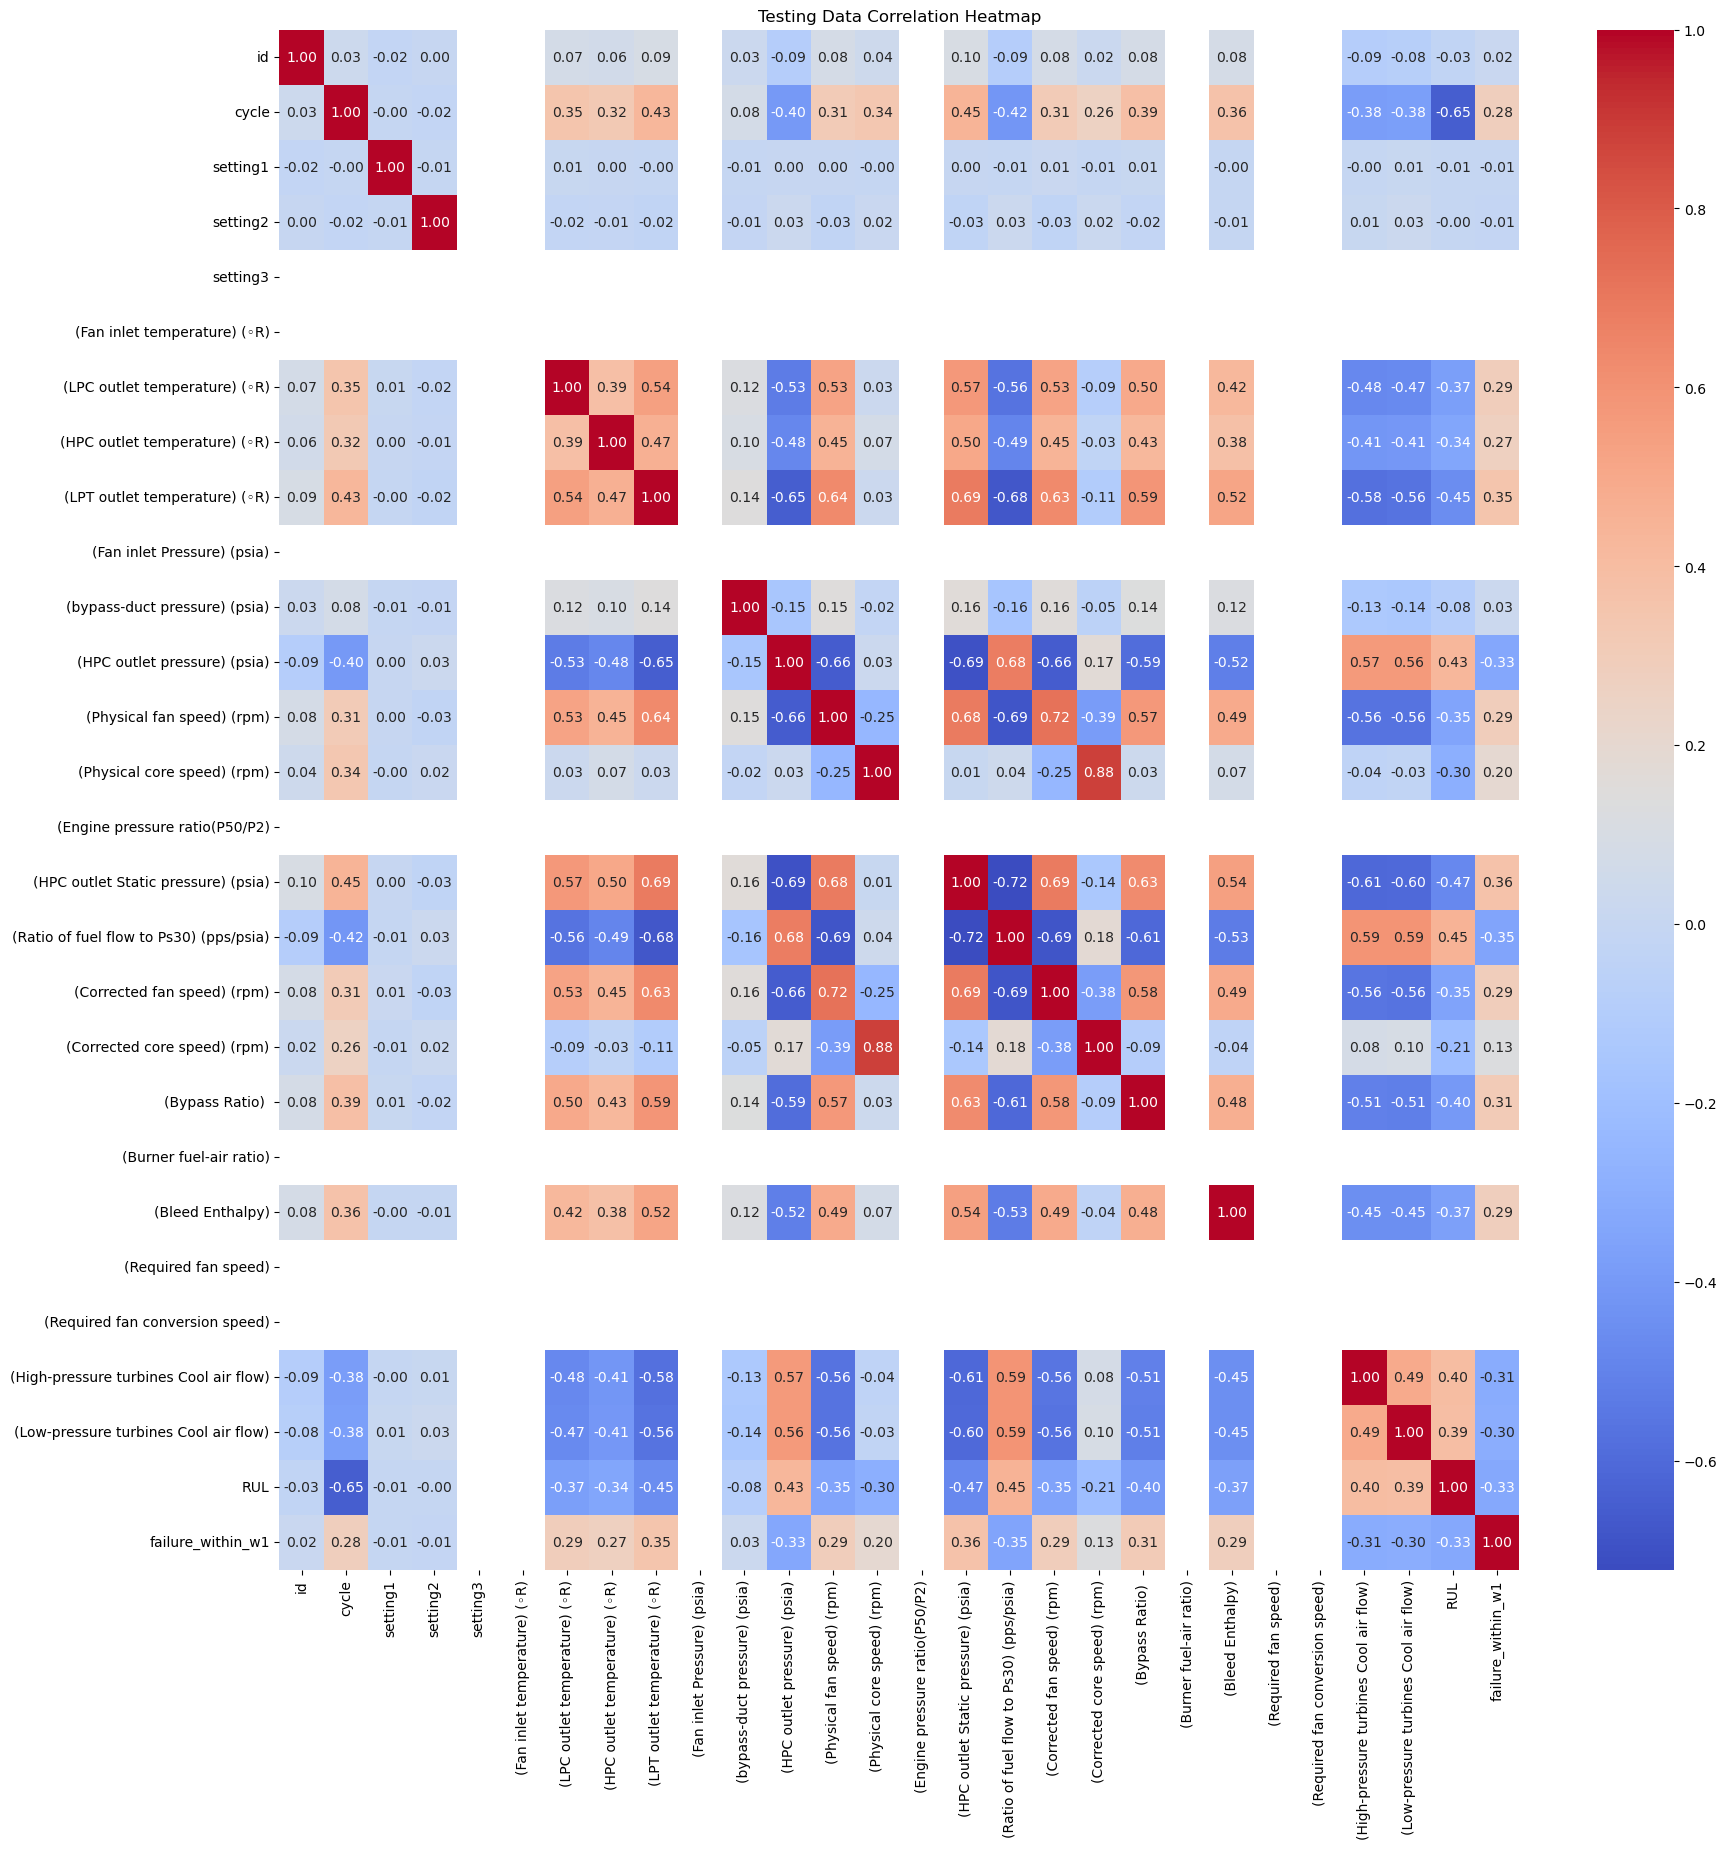

In [52]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Plot the testing data correlation heatmap
sns.heatmap(test_corr, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Testing Data Correlation Heatmap')

plt.show()

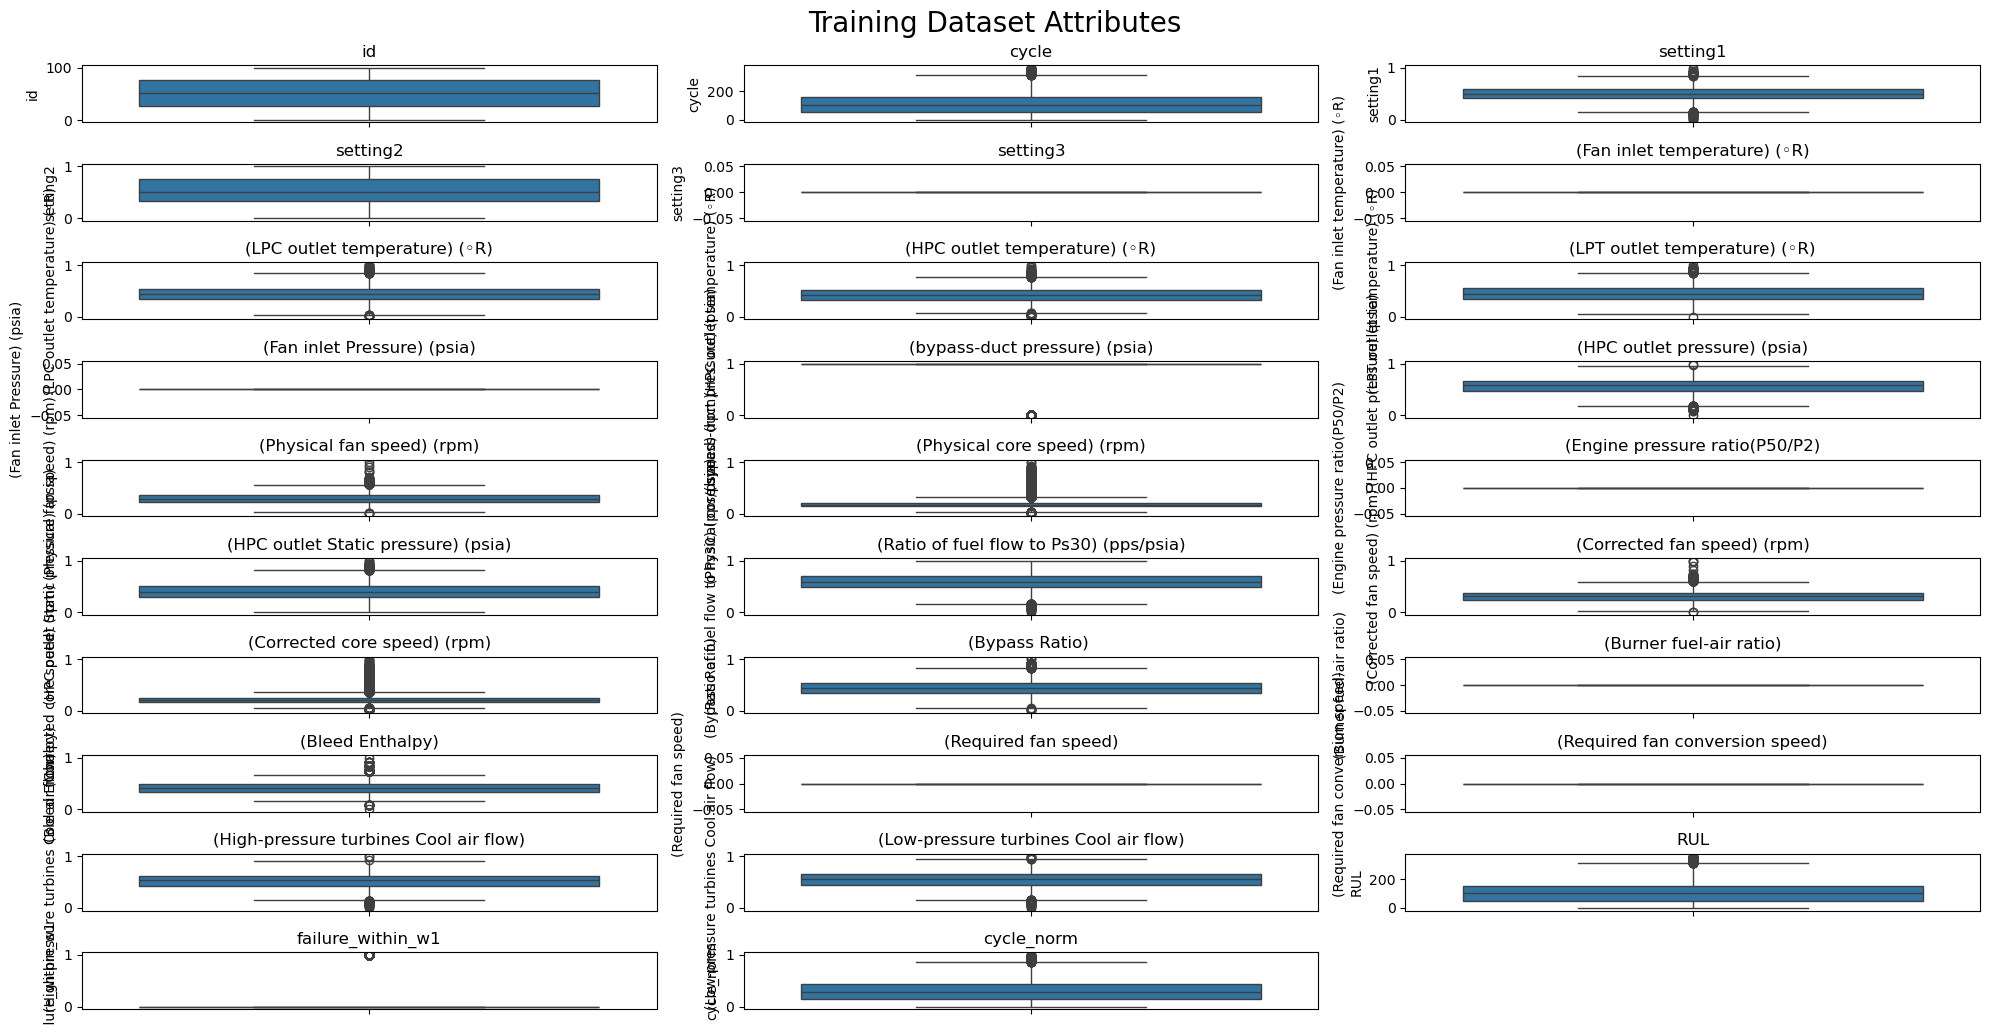

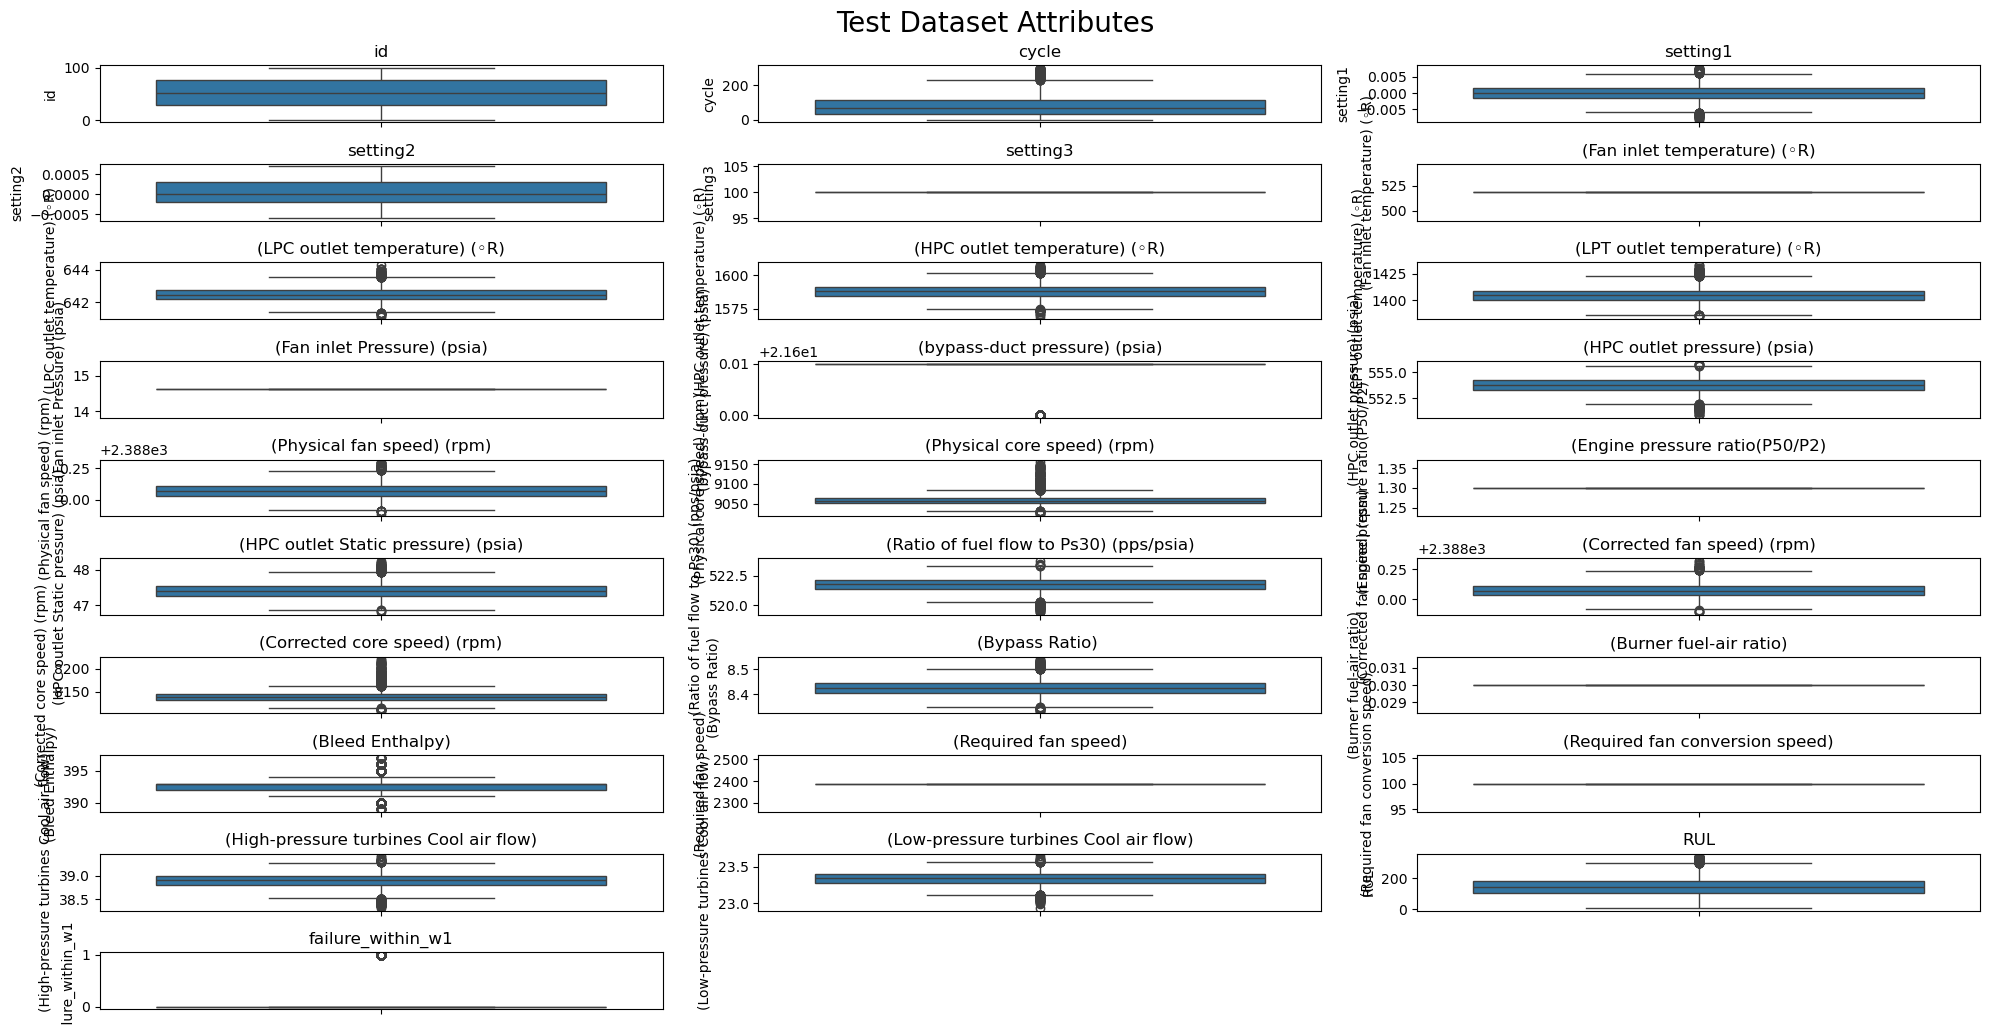

In [53]:
def plot_boxplots(df, title):
    # Set the size of the plot
    plt.figure(figsize=(20, 10))

    # Create a boxplot for each attribute
    for i, column in enumerate(df.columns):
        plt.subplot((len(df.columns) + 2) // 3, 3, i + 1)  # Adjust subplot grid as necessary
        sns.boxplot(y=df[column])
        plt.title(column)
        plt.tight_layout()

    plt.suptitle(title, fontsize=20, y=1.02)  # Add title above all subplots
    plt.show()

# Plot boxplots for training dataset
plot_boxplots(train_df, 'Training Dataset Attributes')

# Plot boxplots for test dataset
plot_boxplots(test_df, 'Test Dataset Attributes')

In [54]:
def remove_outliers(df, factor=1.5):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (factor * IQR)
        upper_bound = Q3 + (factor * IQR)

        # Filter out outliers from the DataFrame
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df


In [70]:
# Remove outliers from the training dataset
train_df = remove_outliers(train_df)

# Remove outliers from the test dataset
test_df = remove_outliers(test_df)


In [56]:
print("Cleaned Training Set Shape:", train_df.shape)
print("Cleaned Test Set Shape:", test_df.shape)

Cleaned Training Set Shape: (15816, 29)
Cleaned Test Set Shape: (10427, 28)


In [78]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()

# Apply the transformation to the training and test data
train_scaled = scaler.fit_transform(train_df.drop(columns=['id', 'cycle', 'RUL', 'failure_within_w1']))
test_scaled = scaler.transform(test_df.drop(columns=['id', 'cycle', 'RUL', 'failure_within_w1']))

# Convert back to DataFrame for consistency
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(columns=['id', 'cycle', 'RUL', 'failure_within_w1']).columns)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(columns=['id', 'cycle', 'RUL', 'failure_within_w1']).columns)


In [80]:
# Prepare the LSTM data after scaling
X_train_lstm_scaled, y_train_lstm_scaled = prepare_lstm_data(train_df)
X_test_lstm_scaled, y_test_lstm_scaled = prepare_lstm_data(test_df)

# Redefine and retrain the LSTM model with the scaled data
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train_lstm_scaled.shape[1], X_train_lstm_scaled.shape[2]), return_sequences=True))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train_lstm_scaled, y_train_lstm_scaled, epochs=20, batch_size=64, validation_split=0.2, verbose=1)

# Make predictions
y_pred_lstm_scaled = model_lstm.predict(X_test_lstm_scaled)

# Evaluate the model
mse_lstm_scaled = mean_squared_error(y_test_lstm_scaled, y_pred_lstm_scaled)
print("LSTM Model with Scaled Data Mean Squared Error:", mse_lstm_scaled)


/Users/shriyansh/Documents/chrome-downloads/anaconda/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 16840.7129 - val_loss: 17551.2129
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - loss: 13322.2070 - val_loss: 15390.3184
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 11698.6055 - val_loss: 13551.5059
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - loss: 9993.7637 - val_loss: 11961.9541
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - loss: 8734.7549 - val_loss: 10582.2334
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - loss: 7480.3896 - val_loss: 9394.5547
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - loss: 6574.0391 - val_loss: 8379.1025
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - loss: 5751.0874 - val_loss: 7507.3423
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - loss: 5020.0596 - val_loss: 6584.8760
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - loss: 4303.1177 - val_loss: 5838.6348
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms

In [79]:
# Use the transformed features (min-max scaled or standardized) for XGBoost
X_train_xgb_scaled = train_scaled_df
X_test_xgb_scaled = test_scaled_df

# Train the XGBoost model again
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                             max_depth=5, alpha=10, n_estimators=100)

model_xgb.fit(X_train_xgb_scaled, y_train_xgb)

# Make predictions
y_pred_xgb_scaled = model_xgb.predict(X_test_xgb_scaled)

# Evaluate the model
mse_xgb_scaled = mean_squared_error(y_test_xgb, y_pred_xgb_scaled)
r2_xgb_scaled = r2_score(y_test_xgb, y_pred_xgb_scaled)
print("XGBoost Model with Scaled Data Mean Squared Error:", mse_xgb_scaled)
print("XGBoost Model with Scaled Data R2 Score:", r2_xgb_scaled)


XGBoost Model with Scaled Data Mean Squared Error: 8777.458984375
XGBoost Model with Scaled Data R2 Score: -2.5945825576782227
